In [142]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats
import random
import copy

**Data**

* Currently using the Broward County data set from ProPublica (https://github.com/propublica/compas-analysis/blob/master/compas-scores.csv).  
* Inlcudes defendant sex, age, # priors, charge, COMPAS score, and recidivism status.
* Does not include judge's decision about the defendant.  Martina tried getting this information, but had to query each defendant individually.
* Right now, we are using synthetic data to get around this hurdle -- we estimate the judge's decision (detain / release) via linear regression on defendant age and # priors.   
* Alternative datasets to consider for the future.
 * VSVC:  Stevenson used in https://www.econstor.eu/bitstream/10419/215249/1/dp12853.pdf.  "The primary data source is the VCSC, which collects and maintains records on all felony sentences in the state of Virginia since 1995."  Contains defendant profile, risk score (not COMPAS), and judge's sentencing decisions.

In [143]:
# import data
df_data = pd.read_csv('people.csv')

# only keep relevant fields, only keep rows with recidivism recorded
fields = ['race', 'age', 'priors_count', 'decile_score', 'is_recid']
df_data = df_data[fields]
df_data = df_data[df_data['is_recid'] >= 0] # -1 signals no value
df_data = df_data[df_data['decile_score'] >= 0] # -1 signals no value
df_data.head()

,race,age,priors_count,decile_score,is_recid
0,Other,69,0,1,0
2,African-American,34,0,3,1
3,African-American,24,4,4,1
4,African-American,23,1,8,0
5,Other,43,2,1,0


**Model Specifications**

**Variables**

$ \{x_{1}, x_{2},...x_{k}\} \in X$, Observed features of defendant
 
$\mu_{prior}$, Judge's mean prior belief about a defendant; $\textit{most probable}$ risk prediction.

$\sigma_{prior}$, Standard deviation of judge's prior belief on a defendant; corresponds to a judge's $\textit{uncertainty}$ about prediction

$\mu_{ra}$, Observed algorithmic risk assessment prediction; mean of normally-distributed perceived anchor information

$\sigma_{ra}$, Perceived anchor $\textit{influence}$; Corresponds to std of risk assessment (when perceived as containing a lot of information std will be lower and vice versa).

$q$, Parameter mapping $\mu_{prior},\sigma_{prior}$ onto $\mu_{post},\sigma_{post}$

$scale$, Influence of anchor; lower (closer to zero) = more influence; think this parameter could have been Martina's issue. She had the scale specified such that $\mu_{prior} = \mu_{post}$.

$\mu_{post}$, Judge's mean posterior belief

$\sigma_{post}$, Standard deviation of judge's posterior belief 

$\tau$, Decision making threshold

$\phi_{prior}(\tau;\mu_{prior},\sigma_{prior})$, Gaussian distribution representing judge's prior belief

$\phi_{post}(\tau;\mu_{post},\sigma_{post})$, Gaussian distribution representing the judge's posterior belief

$\Phi_{post}(\tau;\mu_{post},\sigma_{post})$, Probability of drawing a belief from the posterior less than threshold $\tau$

$\hat{y}$, The judge's belief about the probability that the defendant will recidivate.

$y$, Judge's observed decision on defendant, which we just generated synthetically.
 
**Procedure**

Given {$\beta, b, \sigma _{prior}, \tau$, scale}, want to calculate: 

\begin{equation} \mu_{prior} = \beta X + b \end{equation}

\begin{equation}
d = (\mu_{ra}-\mu_{prior})^2
\end{equation}

\begin{equation}
I = e^{-scale*d}
\end{equation}

\begin{equation}
\mu_{post} = I\cdot\mu_{ra} + (1-I)\cdot\mu_{prior}
\end{equation}

\begin{equation}
\sigma_{post} = \sigma_{prior}e^{-I}
\end{equation}

\begin{equation}
\phi(\tau; \mu_{post},\sigma_{post}) = \mathcal{N}(\tau;\mu_{post},\sigma_{post})
\end{equation}

\begin{equation}
\Phi(\tau;\mu_{post},\sigma_{post}) = \int_0^{\tau} \phi_{post}(\tau; \mu_{post},\sigma_{post})
\end{equation}

\begin{equation}
\hat{y}=1-\Phi(\tau;\mu_{post},\sigma_{post}) 
\end{equation}

**Remarks and Questions**
* $\hat{y}$ cannot equal 0 or 1, otherwise the loss function will return nan; currently fixing this issue by adding 1e-10 of noise, an arbitrary number.

In [144]:
# functions to create synthetic data
def calc_mu_prior(df, features, parameters):
    B = parameters['B']
    b = parameters['b']
    
    mu_prior = b + df[features[0]]*B[0] + df[features[1]]*B[1] # make pretty later
    df['mu_prior'] = mu_prior
    return mu_prior

def calc_I(df, parameters):
    scale = parameters['scale']
    
    difference = (df['mu_prior'] - df['decile_score']).abs()
    I = [1-(1/(1+np.exp(-scale*d))) for d in difference]
    df['difference'] = difference
    df['I'] = I
    return difference, I

def calc_mu_post(df, parameters):
    q = parameters['q']
    
    mu_post = df['I']*(df['mu_prior']*(q/(q+1)) + df['decile_score']/(q+1)) + (1-df['I'])*df['mu_prior']
    df['mu_post'] = mu_post
    return mu_post

def calc_sigma_post(df, parameters):
    q = parameters['q']
    sd_prior = parameters['sigma_prior']

    sd_post = [(I[i]*(sd_prior*np.sqrt(q/(q+1))))+((1-I[i])*sd_prior) for i in range(len(mu_prior))]
    df['sigma_post'] = sd_post
    
    return sd_post


def calc_y(df, parameters):
    tau = parameters['tau']
    
    mu_post = df['mu_post'].values
    sigma_post = df['sigma_post'].values
    y_pred = [1 - norm.cdf(tau, loc=mu_post[i], scale=sigma_post[i]) for i in range(len(mu_post))]
    y = [1 if p > 0.5 else 0 for p in y_pred]
    df['y_pred'] = y_pred
    df['y'] = y

In [145]:
# data
scale = 0.1
syn_params = {'B': np.array([[0.1], [1]]),
              'b': 1,
              'q': .5,
              'sigma_prior': 3,
              'tau': 6,
              'scale': scale # lower = more influence
             }
mu_ra = data['decile_score'].values

# calcs
features = ['age', 'priors_count']
calc_mu_prior(df_data, features, syn_params)
calc_I(df_data, syn_params)
calc_mu_post(df_data, syn_params)
calc_sigma_post(df_data, syn_params)
calc_y(df_data, syn_params)
df_data.head()

,race,age,priors_count,decile_score,is_recid,mu_prior,difference,I,mu_post,sigma_post,y_pred,y
0,Other,69,0,1,0,7.9,6.9,0.334033,6.363448,2.630888,0.554938,1
2,African-American,34,0,3,1,4.4,1.4,0.465057,3.965947,2.472775,0.205374,0
3,African-American,24,4,4,1,7.4,3.4,0.415809,6.457499,2.422930,0.574883,1
4,African-American,23,1,8,0,4.3,3.7,0.408541,5.307735,2.447981,0.388669,0
5,Other,43,2,1,0,7.3,6.3,0.347511,5.840456,2.565107,0.475203,0


**Fairness Criteria of Original Predictions**

1. Overall accuracy equity
2. Predictive parity
3. Calibration
4. Statistical parity
5. Equal FPRs and FNRs

In [170]:
# restrict to black and white defendants, add columns for TP, TN, FP, FN
df_data = df_data[df_data.race.isin(['African-American', 'Caucasian'])]
df_data.loc[(df_data['is_recid'] == 1) & (df_data['y'] == 1), 'TP'] = 1
df_data.loc[(df_data['is_recid'] == 0) & (df_data['y'] == 0), 'TN'] = 1
df_data.loc[(df_data['is_recid'] == 0) & (df_data['y'] == 1), 'FP'] = 1
df_data.loc[(df_data['is_recid'] == 1) & (df_data['y'] == 0), 'FN'] = 1
df_data.head()

,race,age,priors_count,decile_score,is_recid,mu_prior,difference,I,mu_post,sigma_post,y_pred,y,ra_new,ra_change,TP,TN,FP,FN
2,African-American,34,0,3,1,4.4,1.4,0.465057,3.965947,2.472775,0.205374,0,7.840438,4.840438,NaN,NaN,NaN,1.0
3,African-American,24,4,4,1,7.4,3.4,0.415809,6.457499,2.422930,0.574883,1,4.033073,0.033073,1.0,NaN,NaN,NaN
4,African-American,23,1,8,0,4.3,3.7,0.408541,5.307735,2.447981,0.388669,0,8.461149,0.461149,NaN,1.0,NaN,NaN
7,Caucasian,41,14,6,1,19.1,13.1,0.212487,17.244282,2.444862,0.999998,1,-42.550876,NaN,1.0,NaN,NaN,NaN
9,Caucasian,39,0,1,0,4.9,3.9,0.403717,3.850335,2.547805,0.199410,0,7.624679,6.624679,NaN,1.0,NaN,NaN


<AxesSubplot:xlabel='race'>

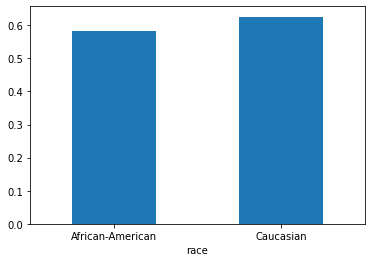

In [171]:
# overall accuracy equity
accuracy = (df_data['is_recid']==df_data['y']).astype(int).groupby(df_data['race']).mean()
accuracy.plot.bar(x='race', y='accuracy', rot=0)

[(0.0, 1.0)]

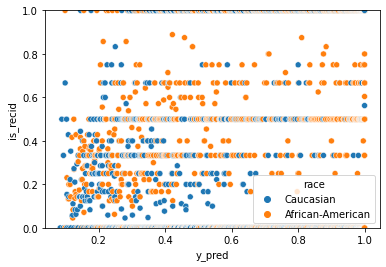

In [172]:
# predictive parity
d = pd.DataFrame(df_data.groupby(['y_pred','race']).agg({'is_recid': 'mean'}))
d = d.reset_index()
im = sns.scatterplot(data=d, x='y_pred', y='is_recid', hue='race')
im.set(ylim=(0,1))

<AxesSubplot:>

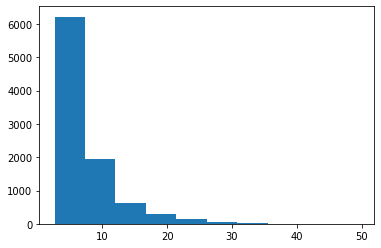

In [173]:
# compare distributions
df_data['mu_post'].hist(bins=10, grid=False)

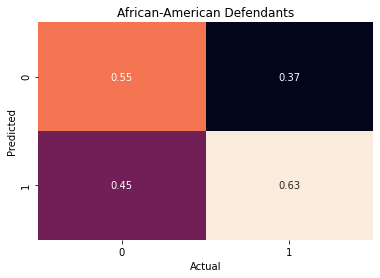

<Figure size 360x360 with 0 Axes>

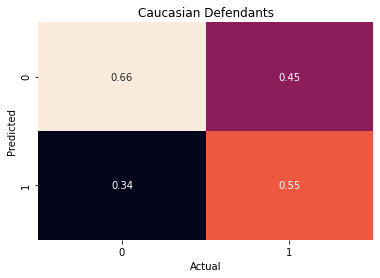

<Figure size 360x360 with 0 Axes>

In [254]:
# compare confusion matrices
cm = pd.crosstab(df_data['y'], df_data.loc[df_data['race'] == 'African-American']['is_recid'], 
                               rownames=['Predicted'], colnames=['Actual'], normalize='columns')
ax = plt.axes()
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.2f', cbar=False, ax=ax)
ax.set_title('African-American Defendants')
plt.show()

cm = pd.crosstab(df_data['y'], df_data.loc[df_data['race'] == 'Caucasian']['is_recid'], 
                               rownames=['Predicted'], colnames=['Actual'], normalize='columns')
ax = plt.axes()
plt.figure(figsize=(5,5));
sns.heatmap(cm, annot=True, fmt='.2f', cbar=False, ax=ax)
ax.set_title('Caucasian Defendants')
plt.show()

In [270]:
# find nearest ra to change decision, if exists
def find_new_ra(df, params):
    tau = params['tau']
    q = params['q']
    sigma_prior = params['sigma_prior']
    mu_prior = df['mu_prior'].values
    ra_orig = df['decile_score'].values
    y_orig = df['y'].values
    
    ra_new = list()
    ra_change = list()
    
    # iterate through defendants
    # for i in range(0, 5):
    for i in range(0, len(ra_orig)):
        # try all possible risk scores, see if any change outcome
        ra_cands = list()
        for ra in range(1, 11):
            d = np.abs(ra-mu_prior[i])
            I = 1-1/(1+np.exp(-scale*d))
            mu_post = I*((mu_prior[i]*(q/(q+1)))+(ra/(q+1)))+(1-I)*mu_prior[i]
            sigma_post = (I*(sigma_prior*np.sqrt(q/(q+1))))+(1-I)*sigma_prior
            y_pred = 1 - norm.cdf(tau, loc=mu_post, scale=sigma_post) 
            y_new = 1 if y_pred > 0.5 else 0 
            # see if different results
            if(y_new != y_orig[i]): 
                ra_cands.append((ra, np.abs(ra - ra_orig[i])))
            # print(ra, ra_orig[i], mu_prior[i], mu_post, sigma_post, y_pred, y_new, y_orig[i])
        if(len(ra_cands) == 0):
            ra_new.append(np.NaN)
            ra_change.append(np.NaN)
        else:
            ra_opt = min(ra_cands, key = lambda t: t[1])
            ra_new.append(ra_opt[0])
            ra_change.append(ra_opt[1])
                                 
                                         
    df['ra_new'] = ra_new
    df['ra_change'] = ra_change
    return(df)

find_new_ra(df_data, syn_params)

,race,age,priors_count,decile_score,is_recid,mu_prior,difference,I,mu_post,sigma_post,y_pred,y,ra_new,ra_change,TP,TN,FP,FN
2,African-American,34,0,3,1,4.4,1.4,0.465057,3.965947,2.472775,0.205374,0,NaN,NaN,NaN,NaN,NaN,1.0
3,African-American,24,4,4,1,7.4,3.4,0.415809,6.457499,2.422930,0.574883,1,1.0,3.0,1.0,NaN,NaN,NaN
4,African-American,23,1,8,0,4.3,3.7,0.408541,5.307735,2.447981,0.388669,0,NaN,NaN,NaN,1.0,NaN,NaN
7,Caucasian,41,14,6,1,19.1,13.1,0.212487,17.244282,2.444862,0.999998,1,NaN,NaN,1.0,NaN,NaN,NaN
9,Caucasian,39,0,1,0,4.9,3.9,0.403717,3.850335,2.547805,0.199410,0,10.0,9.0,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11748,Caucasian,23,0,7,0,3.3,3.7,0.408541,4.307735,2.419784,0.242168,0,NaN,NaN,NaN,1.0,NaN,NaN
11749,African-American,56,0,1,0,6.6,5.6,0.363547,5.242756,2.595973,0.385258,0,5.0,4.0,NaN,1.0,NaN,NaN
11751,African-American,63,5,1,1,12.3,11.3,0.244161,10.460653,2.628265,0.955169,1,NaN,NaN,1.0,NaN,NaN,NaN
11753,Caucasian,22,3,7,1,6.2,0.8,0.480011,6.456006,2.413485,0.574930,1,5.0,2.0,1.0,NaN,NaN,NaN


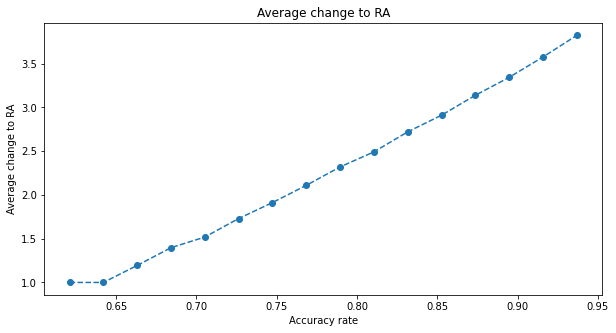

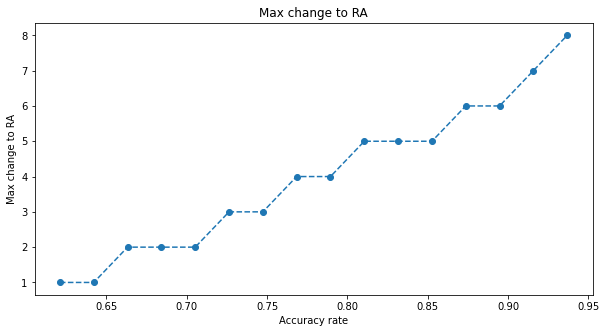

In [298]:
# nudge risk score for defendants to acheive target accuracy rate
# select subset such that average ra_change is minimized
def optimize_accuracy(df, target):
    n = len(df['y'])
    num_changed = math.ceil(target*n - (df['TP'].sum()+df['TN'].sum()))
    ppl_changed = df.nsmallest(num_changed, 'ra_change')
    return(ppl_changed)

accuracy_rates = np.linspace(0.60, 1, 20)
avg_change = []
max_change = []

for rate in accuracy_rates:
    df_new = optimize_accuracy(df_data, rate)
    if(len(df_new) != math.ceil(rate*len(df_data['y']) - (df_data['TP'].sum()+df_data['TN'].sum()))):
        avg_change.append(np.nan)
        max_change.append(np.nan)
    else:
        avg_change.append(df_new['ra_change'].mean())
        max_change.append(df_new['ra_change'].max())

plt.figure(figsize=(10, 5))
plt.plot(accuracy_rates, avg_change, linestyle='--', marker='o')
plt.title('Average change to RA')
plt.xlabel('Accuracy rate')
plt.ylabel('Average change to RA')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_rates, max_change, linestyle='--', marker='o')
plt.title('Max change to RA')
plt.xlabel('Accuracy rate')
plt.ylabel('Max change to RA')
plt.show()

In [278]:
df_data['FP'].sum()+df_data['FN'].sum()

3717.0

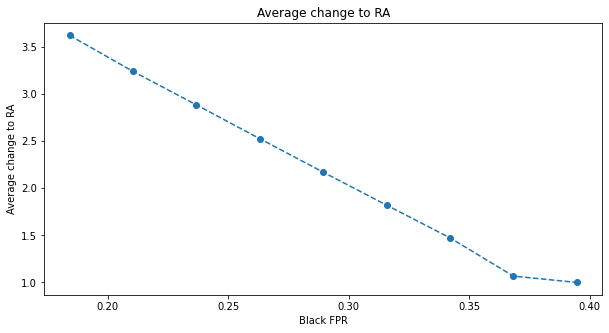

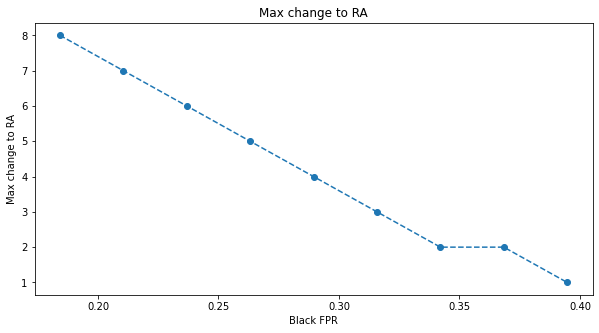

In [293]:
# nudge risk score for defendants to acheive target FPR for group
# select subset such that average ra_change is minimized
def optimize_FPR(df, target):
    df_FPs = df.loc[df['FP'] == 1]
    df_FPs = df.loc[df['race'] == 'African-American']
    num_changed = math.ceil(df['FP'].sum() - df['TN'].sum()*target/(1-target))
    ppl_changed = df_FPs.nsmallest(num_changed, 'ra_change')
    return(ppl_changed)

FPRs = np.linspace(0, .5, 20)
avg_change = []
max_change = []

for rate in FPRs:
    df_new = optimize_FPR(df_data, rate)
    if(len(df_new) != math.ceil(df_data['FP'].sum() - df_data['TN'].sum()*rate/(1-rate))):
        avg_change.append(np.NaN)
        max_change.append(np.NaN)
    else:
        avg_change.append(df_new['ra_change'].mean())
        max_change.append(df_new['ra_change'].max())

plt.figure(figsize=(10, 5))
plt.plot(FPRs, avg_change, linestyle='--', marker='o')
plt.title('Average change to RA')
plt.xlabel('Black FPR')
plt.ylabel('Average change to RA')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(FPRs, max_change, linestyle='--', marker='o')
plt.title('Max change to RA')
plt.xlabel('Black FPR')
plt.ylabel('Max change to RA')
plt.show()